# Классификация грибов по изображению: съедобный или ядовитый

Этот ноутбук демонстрирует прототип ML-решения для задачи:

> Определить, является ли гриб на фотографии **условно съедобным** или **потенциально ядовитым**.

Мы используем предобученную модель компьютерного зрения **ResNet-50**, обученную на датасете **ImageNet**.
В реальном проекте поверх этой модели нужно дообучить выходной слой на специализированном датасете фотографий грибов. В этом учебном прототипе мы показываем **полный пайплайн**:

- загрузка предобученной модели;
- подготовка изображений;
- построение кастомной головы `edible / poisonous`;
- функция предсказания для загруженной пользователем фотографии.

> **Важно:** этот код-учебный прототип. Он **не подходит** для принятия реальных решений о том, можно ли есть найденный гриб. Для безопасности всегда нужен эксперт-миколог.

## 1. Импорт библиотек


In [60]:
# Базовые импорты PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Torchvision: модели, трансформации, датасеты
from torchvision import models, transforms, datasets

# Работа с изображениями и графиками
from PIL import Image
import matplotlib.pyplot as plt

# Устройство: GPU, если доступен, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cpu


## 2. Конфигурация задачи и предобученная модель

Мы используем ResNet-50, предобученную на ImageNet, и меняем последний слой на 2 выхода:
`[edible, poisonous]`.

В реальном проекте этот слой должен быть дообучен на датасете грибов. В этом ноутбуке мы не проводим тяжёлое обучение, а показываем структуру и прототип предсказания. При желании вы можете добавить загрузку обученных весов из файла.

In [61]:
# Метки классов для задачи
CLASS_NAMES = ["edible", "poisonous"]

class MushroomResNet50(nn.Module):
    # Модель-классификатор грибов на базе ResNet-50.

    def __init__(self, num_classes: int = 2, freeze_backbone: bool = True):
        super().__init__()

        # Загружаем предобученную ResNet-50
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # При желании замораживаем все параметры бэкбона
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Заменяем последний FC-слой на слой с num_classes выходами
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


def load_model(checkpoint_path: str | None = None) -> MushroomResNet50:
    # Создаёт модель и при наличии загружает веса из checkpoint.

    model = MushroomResNet50(num_classes=len(CLASS_NAMES), freeze_backbone=True)
    model.to(device)

    if checkpoint_path is not None:
        try:
            state = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state)
            print(f"✅ Загружены веса модели из {checkpoint_path}")
        except Exception as e:
            print(f"⚠️ Не удалось загрузить веса из {checkpoint_path}: {e}")
            print("Модель будет использовать случайно инициализированный выходной слой.")
    else:
        print("ℹ️ Используется модель с предобученным бэкбоном и случайным выходным слоем.")

    model.eval()
    return model


## 3. Предобработка изображений и функция предсказания

ResNet-50 ожидает вход размером 224×224 с нормализацией как в ImageNet. Опишем трансформации и функцию `predict_image`, которая:

1. Загружает изображение;
2. Применяет трансформации;
3. Прогоняет через модель;
4. Возвращает предсказанный класс и вероятности.

In [62]:
# Трансформации такие же, как для моделей ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

def preprocess_image(img_path: str) -> torch.Tensor:

    # Загружает изображение и подготавливает его для модели.
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)  # добавляем размер батча
    return img, x

@torch.no_grad()
def predict_image(model: MushroomResNet50, img_path: str):

    # Делает предсказание для одного изображения.
    img, x = preprocess_image(img_path)
    x = x.to(device)

    logits = model(x)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # находим класс с максимальной вероятностью
    idx = int(np.argmax(probs))
    label = CLASS_NAMES[idx]

    prob_dict = {
        CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))
    }

    return img, label, prob_dict


In [63]:
# Пути к папкам с данными
train_dir = "data/train"
val_dir = "data/val"

# Датасеты (структура папок: class_name / images)
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Классы в датасете:", train_dataset.classes)

Классы в датасете: ['edible', 'poisonous']


## 4. Обучение модели

In [64]:
num_epochs = 3
model = MushroomResNet50(num_classes=2, freeze_backbone=True).to(device)

criterion = nn.CrossEntropyLoss()
# обучаем только новый последний слой
optimizer = torch.optim.Adam(model.backbone.fc.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # быстрая валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total if total > 0 else 0
    print(f"Эпоха {epoch+1}/{num_epochs} | loss={epoch_loss:.4f} | val_acc={val_acc:.3f}")

# сохраняем веса
torch.save(model.state_dict(), "mushroom_resnet50.pth")
print("✅ Веса обученной модели сохранены в mushroom_resnet50.pth")

Эпоха 1/3 | loss=0.7091 | val_acc=0.500
Эпоха 2/3 | loss=0.6413 | val_acc=0.625
Эпоха 3/3 | loss=0.5937 | val_acc=0.625
✅ Веса обученной модели сохранены в mushroom_resnet50.pth


## 5. Загрузка изображения гриба в Colab

В этой ячейке можно загрузить фотографию гриба с локального компьютера. Colab сохранит её в файловую систему виртуальной машины.

Загрузите *крупный, хорошо различимый* снимок одиночного гриба.

In [71]:
from google.colab import files
import os

upload_result = files.upload()

# Берём первое загруженное имя файла
if len(upload_result) > 0:
    uploaded_filename = list(upload_result.keys())[0]
    image_path = uploaded_filename
    print(f"Файл успешно загружен: {image_path}")
else:
    image_path = None
    print("⚠️ Изображение не было загружено.")

Saving пример 2.jpg to пример 2 (1).jpg
Файл успешно загружен: пример 2 (1).jpg


## 6. Запуск модели и отображение результата


✅ Загружены веса модели из mushroom_resnet50.pth


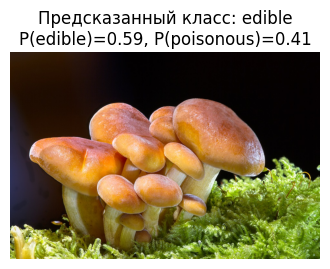

Детальные вероятности по классам:
  edible: 0.5932
  poisonous: 0.4068


In [72]:
# Загружаем модель (без чекпоинта)
model = load_model(checkpoint_path="mushroom_resnet50.pth")

if 'image_path' in globals() and image_path is not None:
    img, label, probs = predict_image(model, image_path)

    # Отображаем изображение с предсказанием
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    title = f"Предсказанный класс: {label}\n"
    title += f"P(edible)={probs['edible']:.2f}, P(poisonous)={probs['poisonous']:.2f}"
    plt.title(title)
    plt.show()

    print("Детальные вероятности по классам:")
    for cls, p in probs.items():
        print(f"  {cls}: {p:.4f}")
else:
    print("Сначала загрузите изображение гриба в предыдущей ячейке.")

## 7. Рекомендации по обучению модели

Для боевого использования модель должна быть дообучена на специализированном датасете изображений грибов (например, из открытых источников).